In [1]:
import skimage
from skimage import measure
from skimage.transform import radon
from skimage.transform import probabilistic_hough_line
from skimage import measure
from scipy import interpolate
from scipy import stats
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [2]:
import pickle
df=pd.read_pickle("./LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
waferMap          811457 non-null object
dieSize           811457 non-null float64
lotName           811457 non-null object
waferIndex        811457 non-null float64
trianTestLabel    811457 non-null object
failureType       811457 non-null object
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


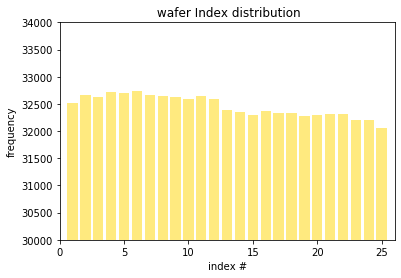

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline


uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

In [4]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim
150927,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3532.0,lot9720,23.0,[],[],"(64, 71)"
48656,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5085.0,lot4045,15.0,[],[],"(87, 74)"
236353,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1791.0,lot14767,9.0,[],[],"(46, 50)"
70501,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",846.0,lot5290,14.0,[],[],"(33, 33)"
52844,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5342.0,lot4292,12.0,[],[],"(89, 76)"


In [5]:
max(df.waferMapDim), min(df.waferMapDim)

((300, 202), (6, 21))

In [6]:
uni_waferDim=np.unique(df.waferMapDim, return_counts=True)
uni_waferDim[0].shape[0]

632

In [7]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

/home/ds4user4/miniconda3/envs/dm_env/lib/python3.7/site-packages/pandas/core/internals/managers.py:1937: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


In [8]:
tol_wafers = df.shape[0]
tol_wafers

811457

In [9]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

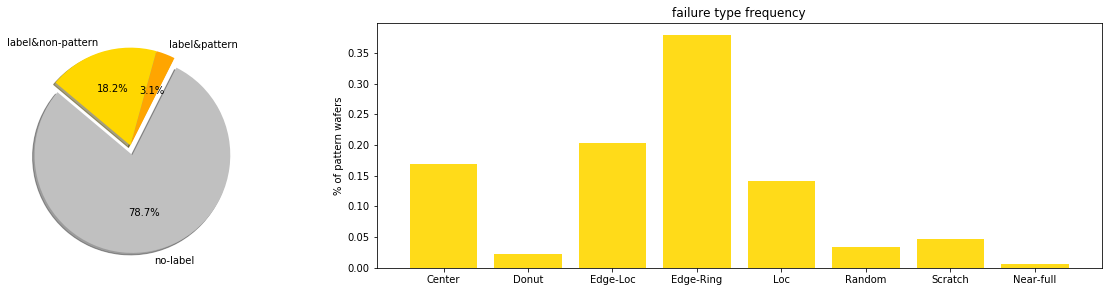

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['silver', 'orange', 'gold']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label&pattern','label&non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='gold', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

In [11]:
df100 = df[df.lotName == "lot10590"]
df100

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
165606,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 1,...",533.0,lot10590,1.0,[],[],"(26, 26)",[],[]
165607,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",533.0,lot10590,2.0,[],[],"(26, 26)",[],[]
165608,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot10590,3.0,[],[],"(26, 26)",[],[]
165609,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1,...",533.0,lot10590,4.0,[[Training]],[[Edge-Loc]],"(26, 26)",2,0
165610,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot10590,5.0,[],[],"(26, 26)",[],[]
165611,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",533.0,lot10590,6.0,[],[],"(26, 26)",[],[]
165612,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",533.0,lot10590,7.0,[],[],"(26, 26)",[],[]
165613,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 1,...",533.0,lot10590,8.0,[[Training]],[[Edge-Loc]],"(26, 26)",2,0
165614,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 2,...",533.0,lot10590,9.0,[],[],"(26, 26)",[],[]
165615,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 2,...",533.0,lot10590,10.0,[],[],"(26, 26)",[],[]


In [12]:
df1 = df[df.trianTestLabel == "Training"]
df2 = df[df.trianTestLabel == "Test"]
df3 = pd.concat([df1,df2])
df3 = df3.reset_index()
df3 = df3.join(pd.DataFrame(columns=['cycle']))
df3['waferIndex'] = df3['waferIndex'].astype(int)
df3['cycle'] = 'no'
df3 = df3.drop(['index'], axis=1)
df3

/home/ds4user4/miniconda3/envs/dm_env/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1069: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x, y, op)


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum,cycle
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1,[[Training]],[[none]],"(45, 48)",8,0,no
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2,[[Training]],[[none]],"(45, 48)",8,0,no
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3,[[Training]],[[none]],"(45, 48)",8,0,no
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4,[[Training]],[[none]],"(45, 48)",8,0,no
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5,[[Training]],[[none]],"(45, 48)",8,0,no
...,...,...,...,...,...,...,...,...,...,...
172945,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21,[[Test]],[[Edge-Loc]],"(26, 30)",2,1,no
172946,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22,[[Test]],[[Edge-Loc]],"(26, 30)",2,1,no
172947,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23,[[Test]],[[Edge-Ring]],"(26, 30)",3,1,no
172948,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24,[[Test]],[[Edge-Loc]],"(26, 30)",2,1,no


In [13]:
df3.to_excel('./cycle.xlsx')

In [14]:
for i in range(1,172924):
    if df3.failureType[i] != 'none':
        for j in range(2,25,2):
            if df3.lotName[i] == df3.lotName[i+j] and df3.failureType[i] == df3.failureType[i+j] and df3.failureType[i] != df3.failureType[i+1] and df3.failureType[i] != df3.failureType[i-1] and df3.cycle[i] == 'no': 
                df3.cycle[i] = '2cycle'
                df3.cycle[i+j] = '2cycle'
            else: break

        for j in range(3,25,3):
            if df3.lotName[i] == df3.lotName[i+j] and df3.failureType[i] == df3.failureType[i+j] and df3.failureType[i] != df3.failureType[i+1] and df3.failureType[i] != df3.failureType[i-1] and df3.cycle[i] == 'no': 
                df3.cycle[i] = '3cycle' 
                df3.cycle[i+j] = '3cycle' 
            else: break

        for j in range(4,25,4):
            if df3.lotName[i] == df3.lotName[i+j] and df3.failureType[i] == df3.failureType[i+j] and df3.failureType[i] != df3.failureType[i+1] and df3.failureType[i] != df3.failureType[i-1] and df3.cycle[i] == 'no': 
                df3.cycle[i] = '4cycle' 
                df3.cycle[i+j] = '4cycle'
            else: break

        for j in range(5,25,5):
            if df3.lotName[i] == df3.lotName[i+j] and df3.failureType[i] == df3.failureType[i+j] and df3.failureType[i] != df3.failureType[i+1] and df3.failureType[i] != df3.failureType[i-1] and df3.cycle[i] == 'no': 
                df3.cycle[i] = '5cycle' 
                df3.cycle[i+j] = '5cycle' 
            else: break
                

/home/ds4user4/miniconda3/envs/dm_env/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ds4user4/miniconda3/envs/dm_env/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ds4user4/miniconda3/envs/dm_env/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ds4user4/miniconda3/envs/dm_

In [15]:
df4 = df3[df3.lotName == 'lot10375']
df4

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum,cycle
10828,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",515.0,lot10375,1,[[Training]],[[Center]],"(25, 27)",0,0,no
10829,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2,...",515.0,lot10375,4,[[Training]],[[Center]],"(25, 27)",0,0,no
10830,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,...",515.0,lot10375,22,[[Training]],[[Random]],"(25, 27)",5,0,no
10831,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,...",515.0,lot10375,25,[[Training]],[[Center]],"(25, 27)",0,0,no


In [16]:
df3["cycle"].unique()

array(['no', '4cycle', '5cycle', '2cycle', '3cycle'], dtype=object)

In [25]:
df3

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum,cycle
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1,[[Training]],[[none]],"(45, 48)",8,0,no
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2,[[Training]],[[none]],"(45, 48)",8,0,no
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3,[[Training]],[[none]],"(45, 48)",8,0,no
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4,[[Training]],[[none]],"(45, 48)",8,0,no
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5,[[Training]],[[none]],"(45, 48)",8,0,no
...,...,...,...,...,...,...,...,...,...,...
172945,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2,...",600.0,lot47542,21,[[Test]],[[Edge-Loc]],"(26, 30)",2,1,no
172946,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",600.0,lot47542,22,[[Test]],[[Edge-Loc]],"(26, 30)",2,1,no
172947,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,...",600.0,lot47542,23,[[Test]],[[Edge-Ring]],"(26, 30)",3,1,no
172948,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0,...",600.0,lot47542,24,[[Test]],[[Edge-Loc]],"(26, 30)",2,1,no


In [26]:
df5 = df[df.lotName == 'lot40528']
df5 = df5.reset_index()
df5 = df5.drop(['index'], axis=1)
df5

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 1,...",533.0,lot40528,1.0,[[Test]],[[none]],"(26, 26)",8,1
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1,...",533.0,lot40528,2.0,[[Test]],[[none]],"(26, 26)",8,1
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2, 2,...",533.0,lot40528,3.0,[],[],"(26, 26)",[],[]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2,...",533.0,lot40528,4.0,[[Test]],[[none]],"(26, 26)",8,1
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2,...",533.0,lot40528,5.0,[[Test]],[[Loc]],"(26, 26)",4,1
5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot40528,6.0,[[Test]],[[none]],"(26, 26)",8,1
6,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2, 1,...",533.0,lot40528,7.0,[[Test]],[[none]],"(26, 26)",8,1
7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2,...",533.0,lot40528,8.0,[[Test]],[[none]],"(26, 26)",8,1
8,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",533.0,lot40528,9.0,[],[],"(26, 26)",[],[]
9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1,...",533.0,lot40528,10.0,[[Test]],[[none]],"(26, 26)",8,1


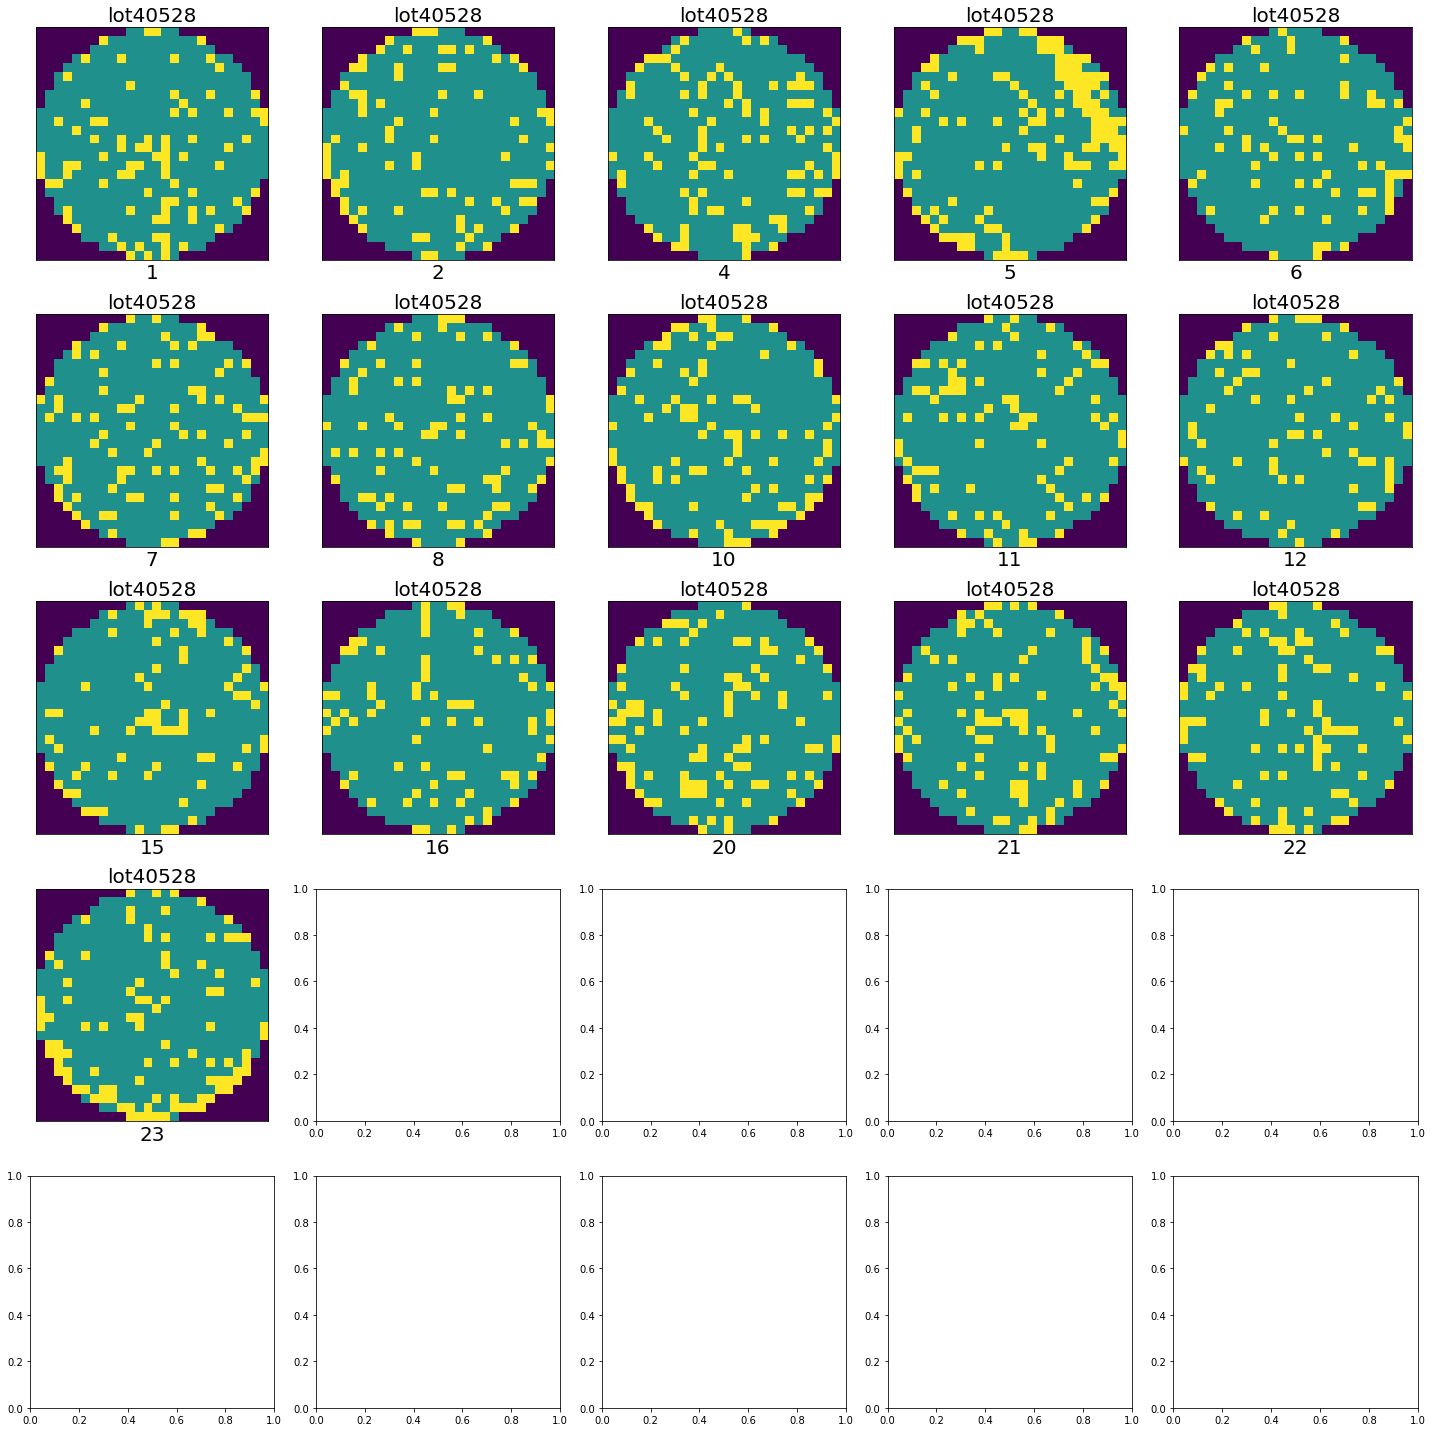

In [18]:
fig, ax = plt.subplots(nrows = 5, ncols = 5, figsize=(20, 20))
ax = ax.ravel(order='C')
for i in range(16):
    img = df5.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df5.lotName[i], fontsize=(20))
    ax[i].set_xlabel(df5.waferIndex[i], fontsize=20)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

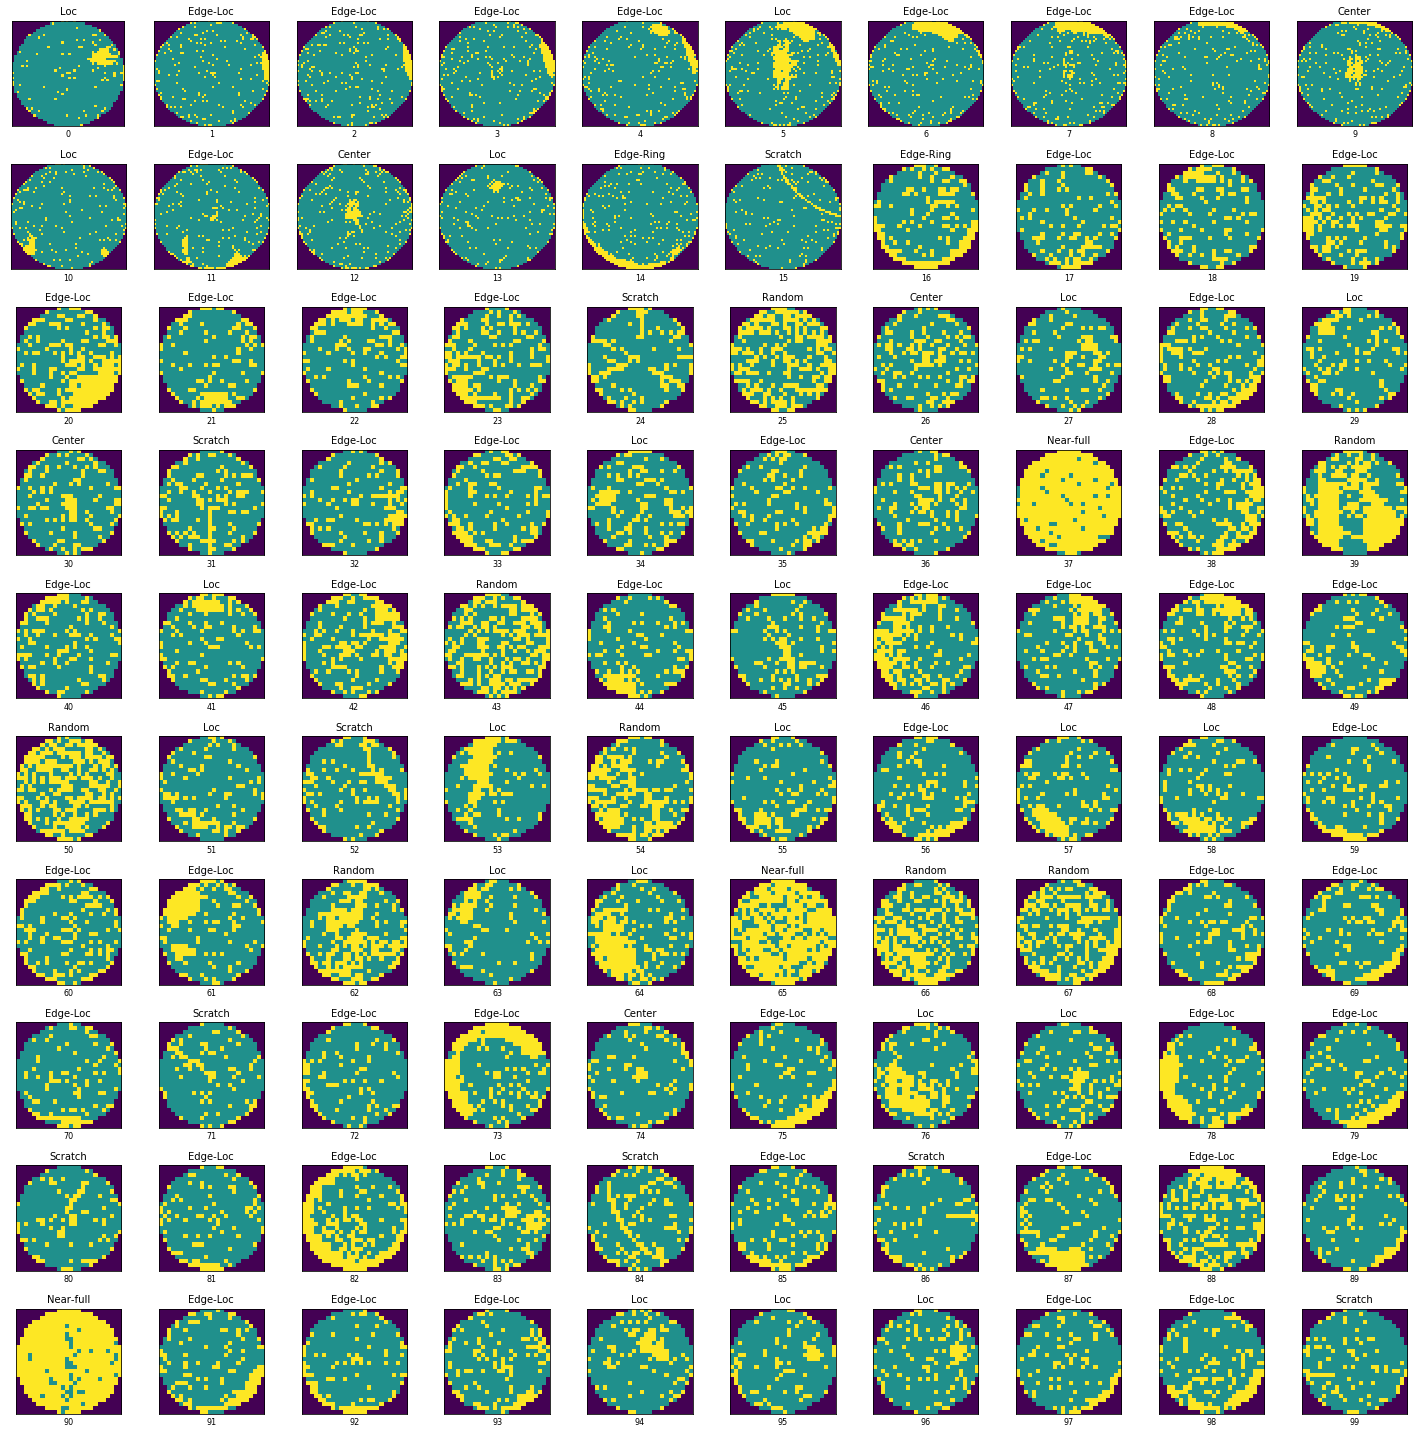

In [19]:
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(20, 20))
ax = ax.ravel(order='C')
for i in range(100):
    img = df_withpattern.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[i][0][0], fontsize=10)
    ax[i].set_xlabel(df_withpattern.index[i], fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

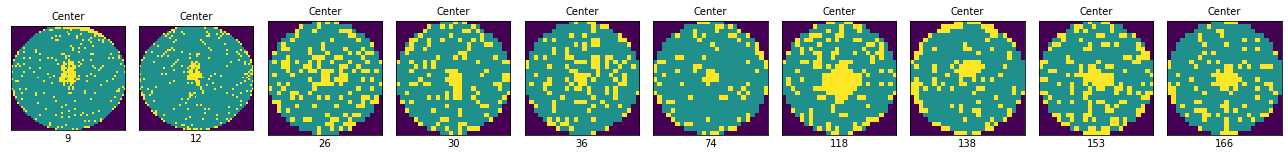

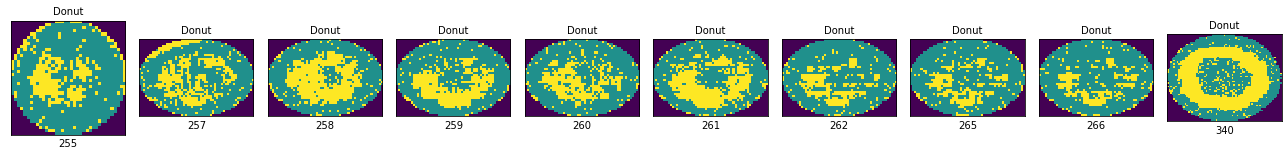

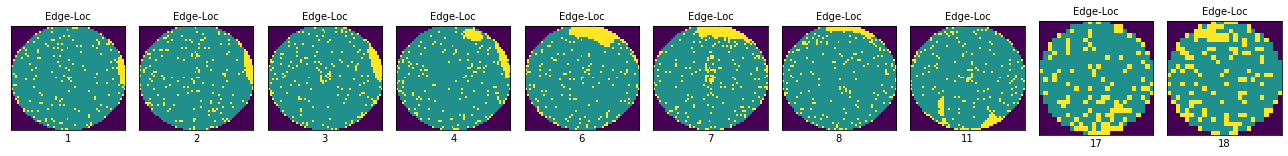

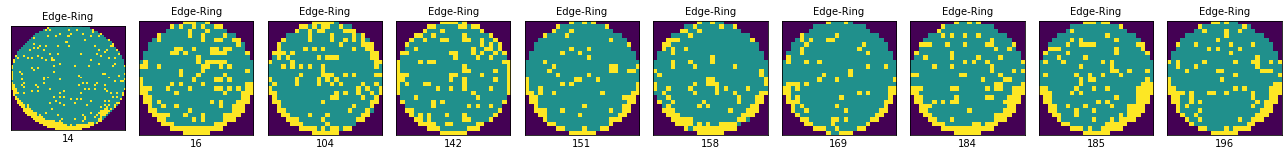

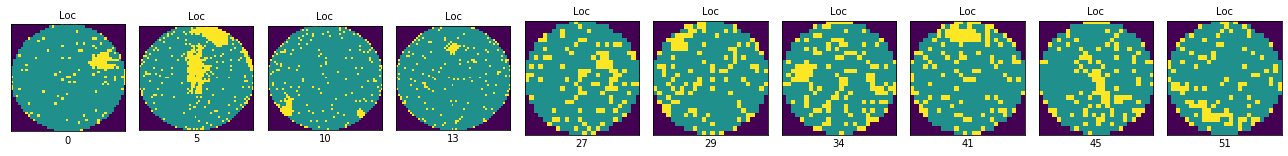

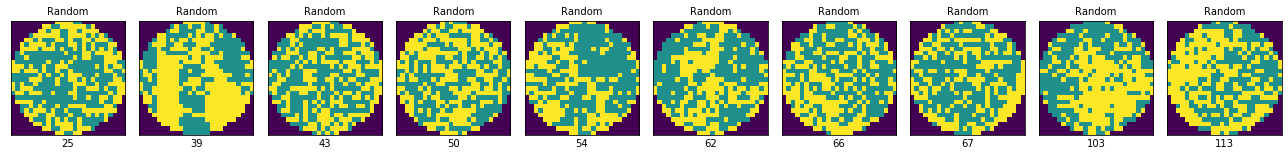

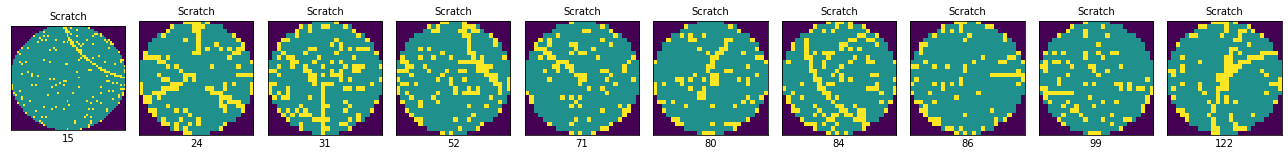

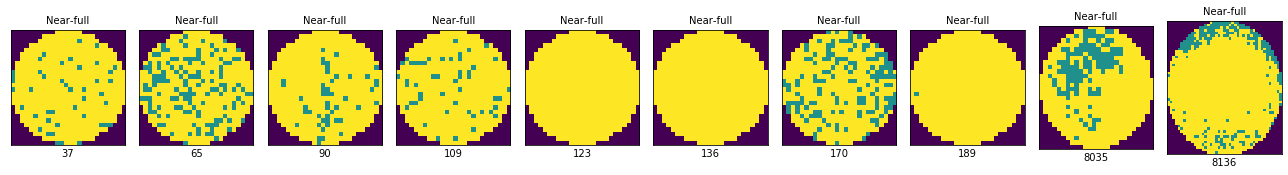

In [20]:
x = [0,1,2,3,4,5,6,7]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(18, 12))
    ax = ax.ravel(order='C')
    for j in [k]:
        img = df_withpattern.waferMap[df_withpattern.failureType==labels2[j]]
        for i in range(10):
            ax[i].imshow(img[img.index[i]])
            ax[i].set_title(df_withpattern.failureType[img.index[i]][0][0], fontsize=10)
            ax[i].set_xlabel(df_withpattern.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    plt.show() 

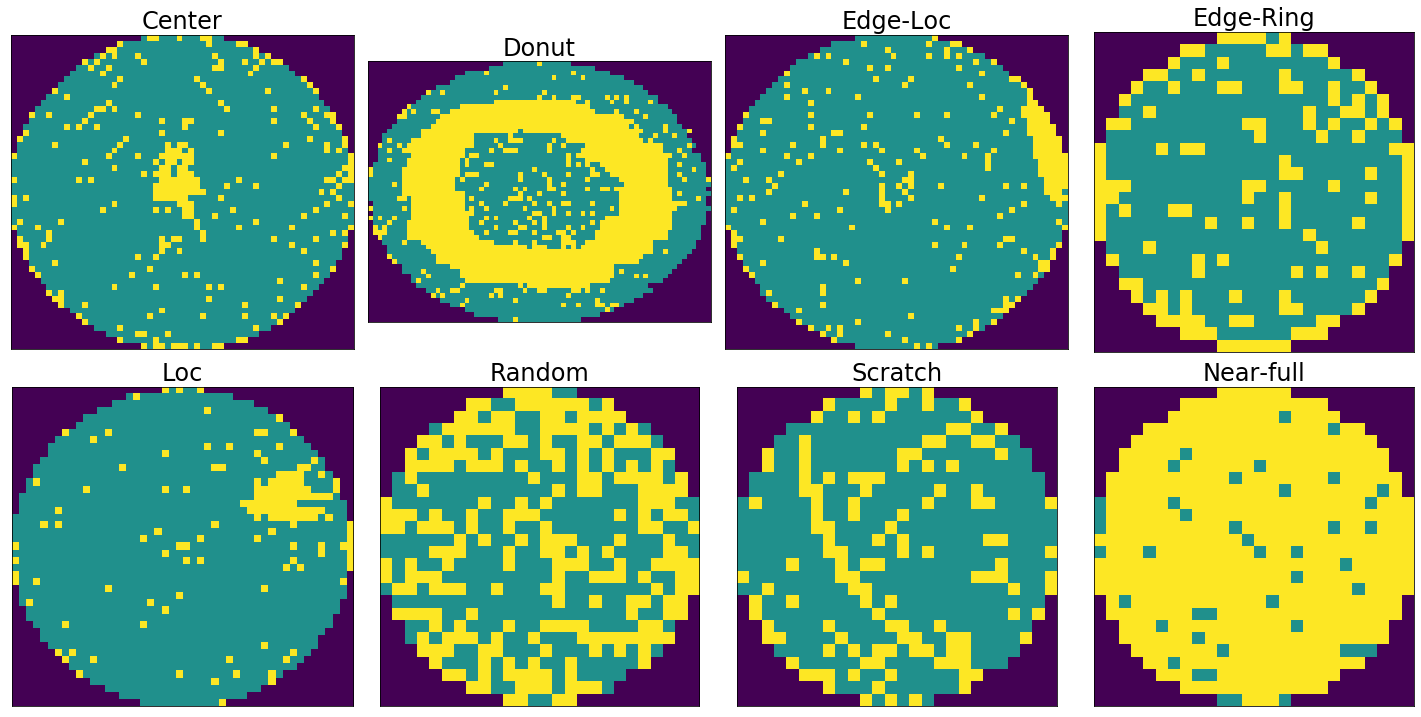

In [21]:
x = [12,340, 3, 142, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

#ind_def = {'Center': 9, 'Donut': 340, 'Edge-Loc': 3, 'Edge-Ring': 16, 'Loc': 0, 'Random': 25,  'Scratch': 84, 'Near-full': 37}
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern.waferMap[x[i]]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[x[i]][0][0],fontsize=24)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

In [22]:

#from skimage import measure
from skimage.transform import radon
from skimage.transform import probabilistic_hough_line
from skimage import measure
from scipy import interpolate
from scipy import stats

In [23]:
def change_val(img):
    img[img==1] =0  
    return img

df_withpattern_copy = df_withpattern.copy()
df_withpattern_copy['new_waferMap'] =df_withpattern_copy.waferMap.apply(change_val)

In [24]:
df_withpattern_copy.lotName[3]

'lot2'

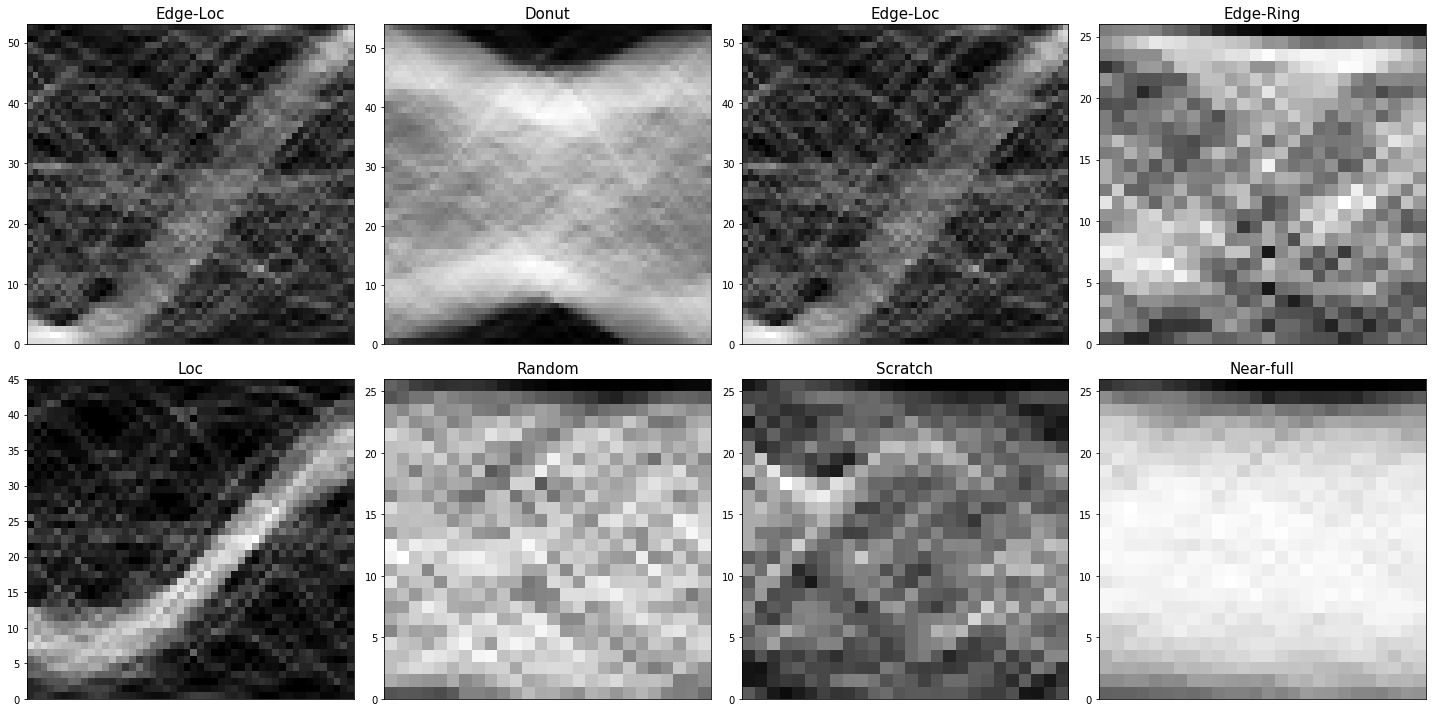

In [52]:
x = [3,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern_copy.waferMap[x[i]]
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)    
      
    ax[i].imshow(sinogram, cmap=plt.cm.Greys_r, extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=15)
    ax[i].set_xticks([])
plt.tight_layout()

plt.show() 

In [29]:
def cubic_inter_mean(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xMean_Row = np.mean(sinogram, axis = 1)
    x = np.linspace(1, xMean_Row.size, xMean_Row.size)
    y = xMean_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xMean_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew

def cubic_inter_std(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xStd_Row = np.std(sinogram, axis=1)
    x = np.linspace(1, xStd_Row.size, xStd_Row.size)
    y = xStd_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xStd_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew  

In [30]:
df_withpattern_copy['fea_cub_mean'] =df_withpattern_copy.waferMap.apply(cubic_inter_mean)
df_withpattern_copy['fea_cub_std'] =df_withpattern_copy.waferMap.apply(cubic_inter_std)

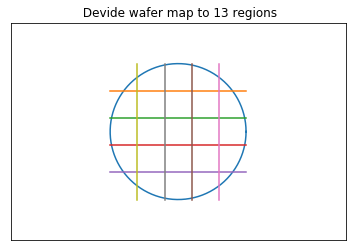

In [31]:
# illustration of 13 regions
an = np.linspace(0, 2*np.pi, 100)
plt.plot(2.5*np.cos(an), 2.5*np.sin(an))
plt.axis('equal')
plt.axis([-4, 4, -4, 4])
plt.plot([-2.5, 2.5], [1.5, 1.5])
plt.plot([-2.5, 2.5], [0.5, 0.5 ])
plt.plot([-2.5, 2.5], [-0.5, -0.5 ])
plt.plot([-2.5, 2.5], [-1.5,-1.5 ])

plt.plot([0.5, 0.5], [-2.5, 2.5])
plt.plot([1.5, 1.5], [-2.5, 2.5])
plt.plot([-0.5, -0.5], [-2.5, 2.5])
plt.plot([-1.5, -1.5], [-2.5, 2.5])
plt.title(" Devide wafer map to 13 regions")
plt.xticks([])
plt.yticks([])
plt.show()

In [32]:
def cal_den(x):
    return 100*(np.sum(x==2)/np.size(x))  

def find_regions(x):
    rows=np.size(x,axis=0)
    cols=np.size(x,axis=1)
    ind1=np.arange(0,rows,rows//5)
    ind2=np.arange(0,cols,cols//5)
    
    reg1=x[ind1[0]:ind1[1],:]
    reg3=x[ind1[4]:,:]
    reg4=x[:,ind2[0]:ind2[1]]
    reg2=x[:,ind2[4]:]

    reg5=x[ind1[1]:ind1[2],ind2[1]:ind2[2]]
    reg6=x[ind1[1]:ind1[2],ind2[2]:ind2[3]]
    reg7=x[ind1[1]:ind1[2],ind2[3]:ind2[4]]
    reg8=x[ind1[2]:ind1[3],ind2[1]:ind2[2]]
    reg9=x[ind1[2]:ind1[3],ind2[2]:ind2[3]]
    reg10=x[ind1[2]:ind1[3],ind2[3]:ind2[4]]
    reg11=x[ind1[3]:ind1[4],ind2[1]:ind2[2]]
    reg12=x[ind1[3]:ind1[4],ind2[2]:ind2[3]]
    reg13=x[ind1[3]:ind1[4],ind2[3]:ind2[4]]
    #print(reg1.to_numpy().sum())
           
    
    fea_reg_den = []
    fea_reg_den = [cal_den(reg1),cal_den(reg2),cal_den(reg3),cal_den(reg4),cal_den(reg5),cal_den(reg6),cal_den(reg7),cal_den(reg8),cal_den(reg9),cal_den(reg10),cal_den(reg11),cal_den(reg12),cal_den(reg13)]
    #fea_reg_den = [reg1,reg2,reg3,reg4,reg5,reg6,reg7,reg8,reg9,reg10,reg11,reg12,reg13]
    return fea_reg_den

In [33]:
df_withpattern['fea_reg']=df_withpattern.waferMap.apply(find_regions)
df_withpattern

,index,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum,fea_reg
0,19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,20.0,[[Training]],[[Loc]],"(45, 48)",4,0,"[3.4722222222222223, 13.703703703703704, 3.472..."
1,36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12.0,[[Training]],[[Edge-Loc]],"(53, 58)",2,0,"[6.0344827586206895, 11.05121293800539, 5.1724..."
2,37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,13.0,[[Training]],[[Edge-Loc]],"(53, 58)",2,0,"[5.862068965517241, 11.320754716981133, 5.0397..."
3,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,14.0,[[Training]],[[Edge-Loc]],"(53, 58)",2,0,"[5.689655172413794, 16.037735849056602, 4.9071..."
4,39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,15.0,[[Training]],[[Edge-Loc]],"(53, 58)",2,0,"[11.551724137931034, 13.07277628032345, 5.0397..."
...,...,...,...,...,...,...,...,...,...,...,...
25514,811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2,...",600.0,lot47542,21.0,[[Test]],[[Edge-Loc]],"(26, 30)",2,1,"[8.666666666666668, 21.153846153846153, 12.777..."
25515,811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",600.0,lot47542,22.0,[[Test]],[[Edge-Loc]],"(26, 30)",2,1,"[1.3333333333333335, 12.179487179487179, 7.222..."
25516,811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]],"(26, 30)",3,1,"[3.3333333333333335, 14.743589743589745, 16.11..."
25517,811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]],"(26, 30)",2,1,"[3.3333333333333335, 23.717948717948715, 15.55..."


In [34]:
df_withpattern.to_excel('./df_withpattern.xlsx')

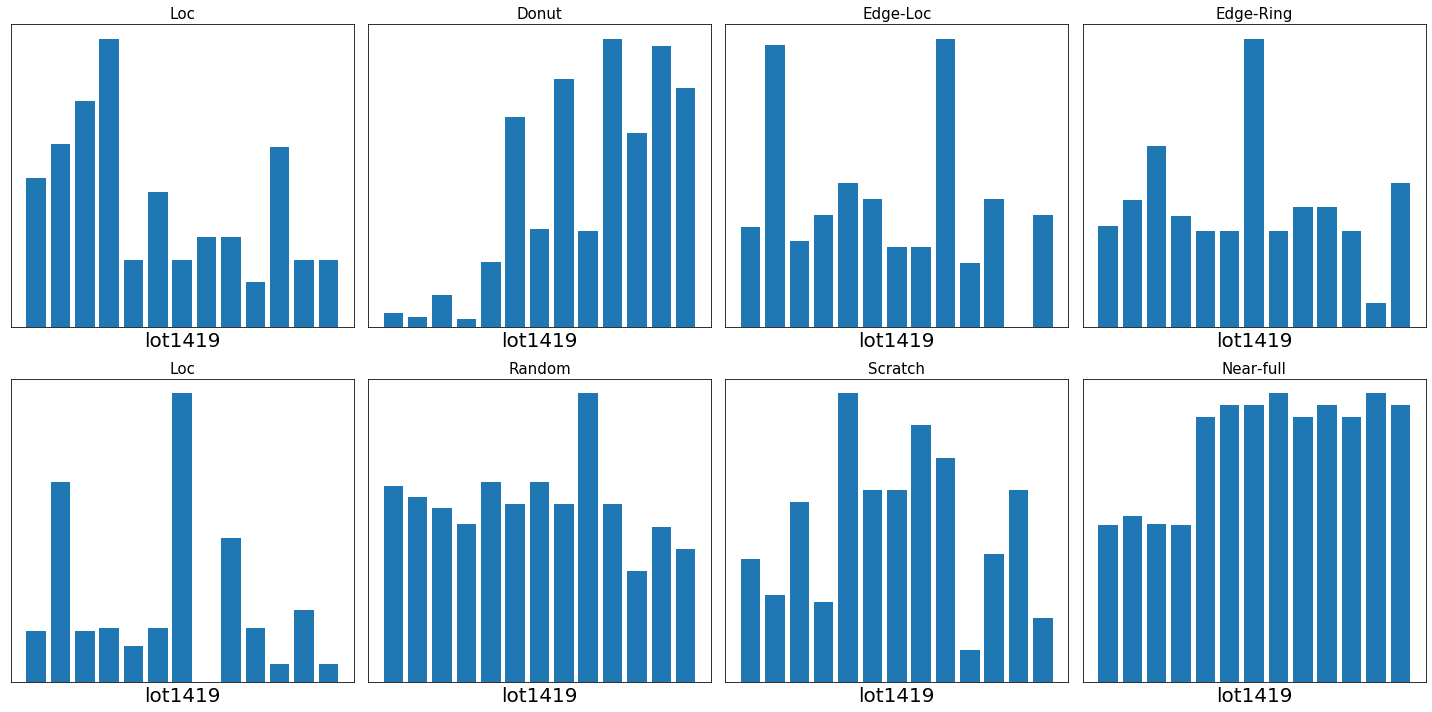

In [35]:
x = [10,360, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,13,13),df_withpattern.fea_reg[x[i]])
    ax[i].set_title(df_withpattern.failureType[x[i]][0][0],fontsize=15)
    ax[i].set_xticks([])
    ax[i].set_xlabel(df_withpattern.lotName[360], fontsize=20)
    ax[i].set_yticks([])

plt.tight_layout()
plt.show() 

In [36]:
df100 = df3.sample(frac=0.05).reset_index(drop=True)

In [37]:
df100

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum,cycle
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3703.0,lot15087,22,[[Training]],[[none]],"(62, 75)",8,0,no
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1485.0,lot43660,4,[[Test]],[[none]],"(45, 42)",8,1,no
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",1109.0,lot45392,9,[[Test]],[[none]],"(39, 37)",8,1,no
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",503.0,lot45073,19,[[Training]],[[none]],"(27, 25)",8,0,no
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1414.0,lot46358,17,[[Test]],[[none]],"(42, 44)",8,1,no
...,...,...,...,...,...,...,...,...,...,...
8643,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2,...",516.0,lot43308,11,[[Training]],[[none]],"(25, 27)",8,0,no
8644,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1972.0,lot15327,7,[[Training]],[[none]],"(51, 50)",8,0,no
8645,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",1109.0,lot45555,23,[[Test]],[[none]],"(39, 37)",8,1,no
8646,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",515.0,lot36599,17,[[Training]],[[Center]],"(25, 27)",0,0,no


In [38]:
def change_val(img):
    img[img==1] =0  
    return img

df_withpattern_copy = df_withpattern.copy()
df_withpattern_copy['new_waferMap'] =df_withpattern_copy.waferMap.apply(change_val)

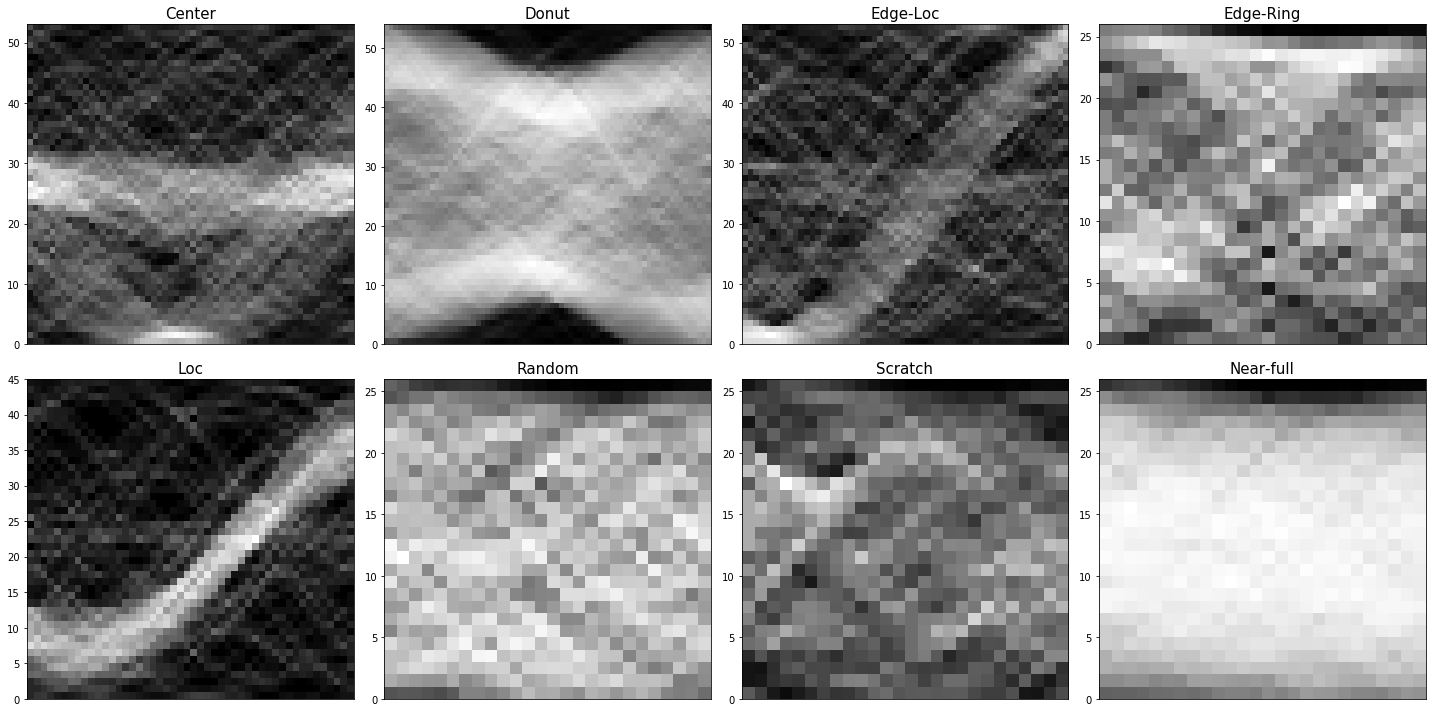

In [39]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern_copy.waferMap[x[i]]
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)    
      
    ax[i].imshow(sinogram, cmap=plt.cm.Greys_r, extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=15)
    ax[i].set_xticks([])
plt.tight_layout()

plt.show() 

In [40]:
def cubic_inter_mean(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xMean_Row = np.mean(sinogram, axis = 1)
    x = np.linspace(1, xMean_Row.size, xMean_Row.size)
    y = xMean_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xMean_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew

def cubic_inter_std(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xStd_Row = np.std(sinogram, axis=1)
    x = np.linspace(1, xStd_Row.size, xStd_Row.size)
    y = xStd_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xStd_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew

In [41]:
df_withpattern_copy['fea_cub_mean'] =df_withpattern_copy.waferMap.apply(cubic_inter_mean)
df_withpattern_copy['fea_cub_std'] =df_withpattern_copy.waferMap.apply(cubic_inter_std)

In [42]:
df_withpattern_copy

,index,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum,fea_reg,new_waferMap,fea_cub_mean,fea_cub_std
0,19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,20.0,[[Training]],[[Loc]],"(45, 48)",4,0,"[3.4722222222222223, 13.703703703703704, 3.472...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.020948312198063167, 0.026683150603641764, 0...","[0.010306353895205664, 0.016225705729273614, 0..."
1,36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12.0,[[Training]],[[Edge-Loc]],"(53, 58)",2,0,"[6.0344827586206895, 11.05121293800539, 5.1724...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.05379317347428998, 0.0598186325125214, 0.05...","[0.03796203303455247, 0.036241439592491875, 0...."
2,37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,13.0,[[Training]],[[Edge-Loc]],"(53, 58)",2,0,"[5.862068965517241, 11.320754716981133, 5.0397...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.04420250213707408, 0.06033372907944151, 0.0...","[0.030784539876323017, 0.041921149511889695, 0..."
3,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,14.0,[[Training]],[[Edge-Loc]],"(53, 58)",2,0,"[5.689655172413794, 16.037735849056602, 4.9071...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.06670148076593406, 0.07083150909994845, 0.0...","[0.04249425363651626, 0.05818754382060698, 0.0..."
4,39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,15.0,[[Training]],[[Edge-Loc]],"(53, 58)",2,0,"[11.551724137931034, 13.07277628032345, 5.0397...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.0640595915524978, 0.0696612239701709, 0.084...","[0.03077572398072894, 0.048465200407665394, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25514,811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2,...",600.0,lot47542,21.0,[[Test]],[[Edge-Loc]],"(26, 30)",2,1,"[8.666666666666668, 21.153846153846153, 12.777...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2,...","[0.03221958716524163, 0.08024342807045874, 0.0...","[0.027967848803154026, 0.0492729973931846, 0.0..."
25515,811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",600.0,lot47542,22.0,[[Test]],[[Edge-Loc]],"(26, 30)",2,1,"[1.3333333333333335, 12.179487179487179, 7.222...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.03216605461998753, 0.04505181629880516, 0.0...","[0.027092115628165127, 0.02505532898484561, 0...."
25516,811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]],"(26, 30)",3,1,"[3.3333333333333335, 14.743589743589745, 16.11...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,...","[0.06052167486923029, 0.10084405992101803, 0.0...","[0.04261373167352511, 0.0357707475798425, 0.03..."
25517,811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]],"(26, 30)",2,1,"[3.3333333333333335, 23.717948717948715, 15.55...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0,...","[0.03769587642803953, 0.09558455494101789, 0.0...","[0.02772428416098711, 0.060102574782748254, 0...."


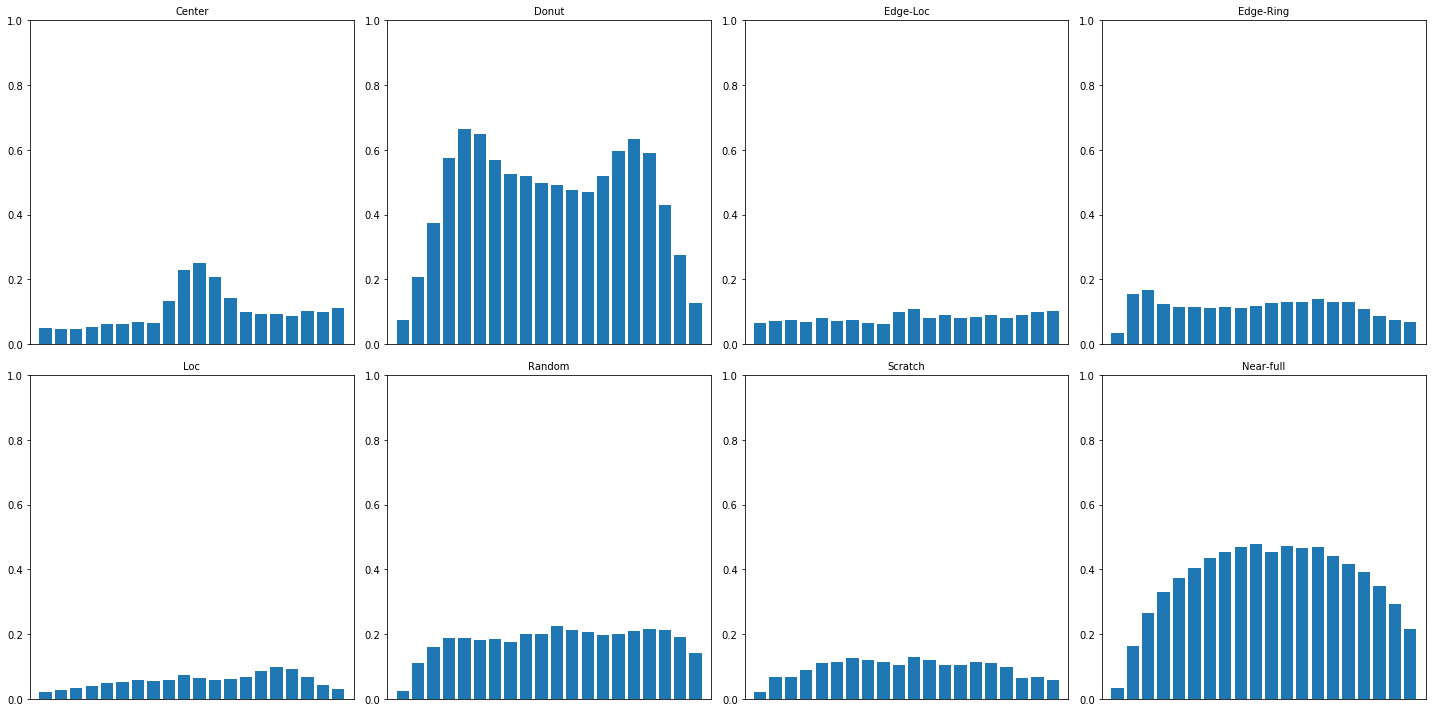

In [43]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,20,20),df_withpattern_copy.fea_cub_mean[x[i]])
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_xlim([0,21])   
    ax[i].set_ylim([0,1])
plt.tight_layout()
plt.show() 

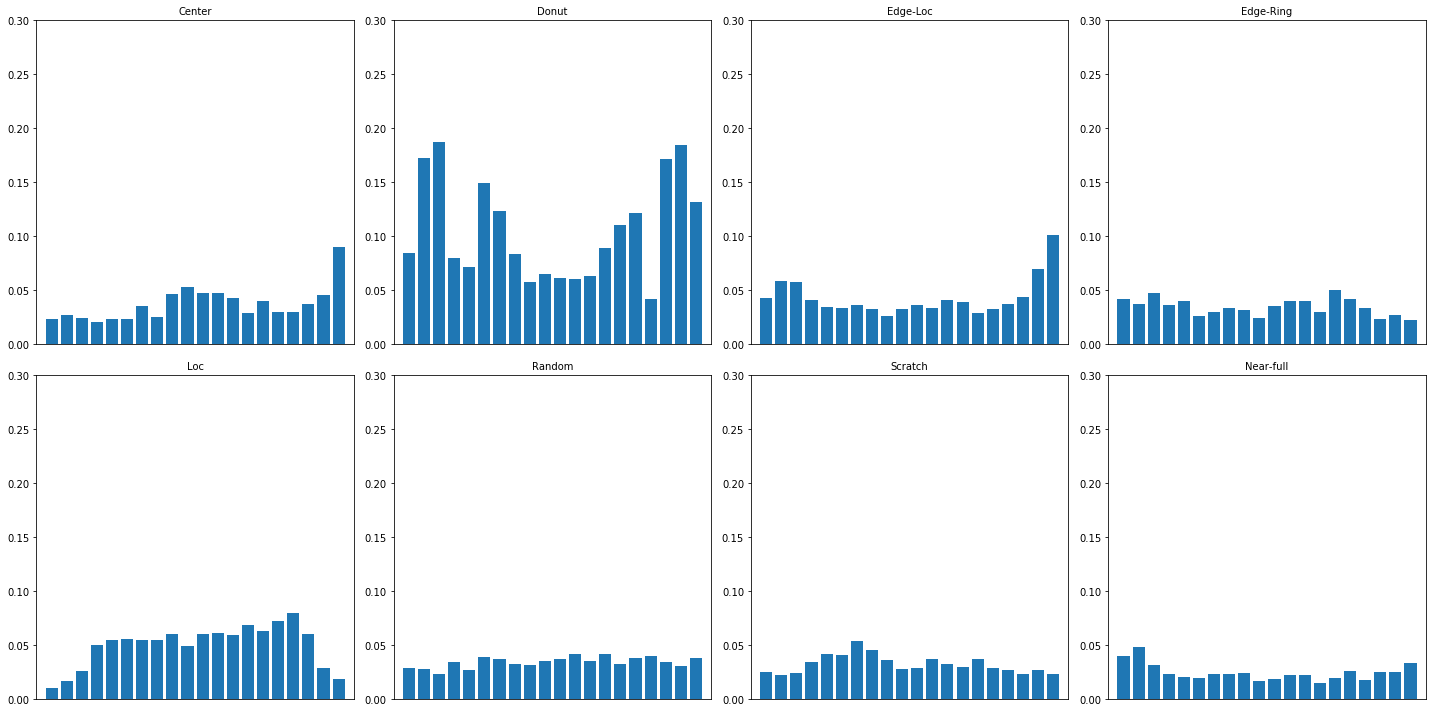

In [44]:
fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,20,20),df_withpattern_copy.fea_cub_std[x[i]])
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_xlim([0,21])   
    ax[i].set_ylim([0,0.3])
plt.tight_layout()
plt.show() 

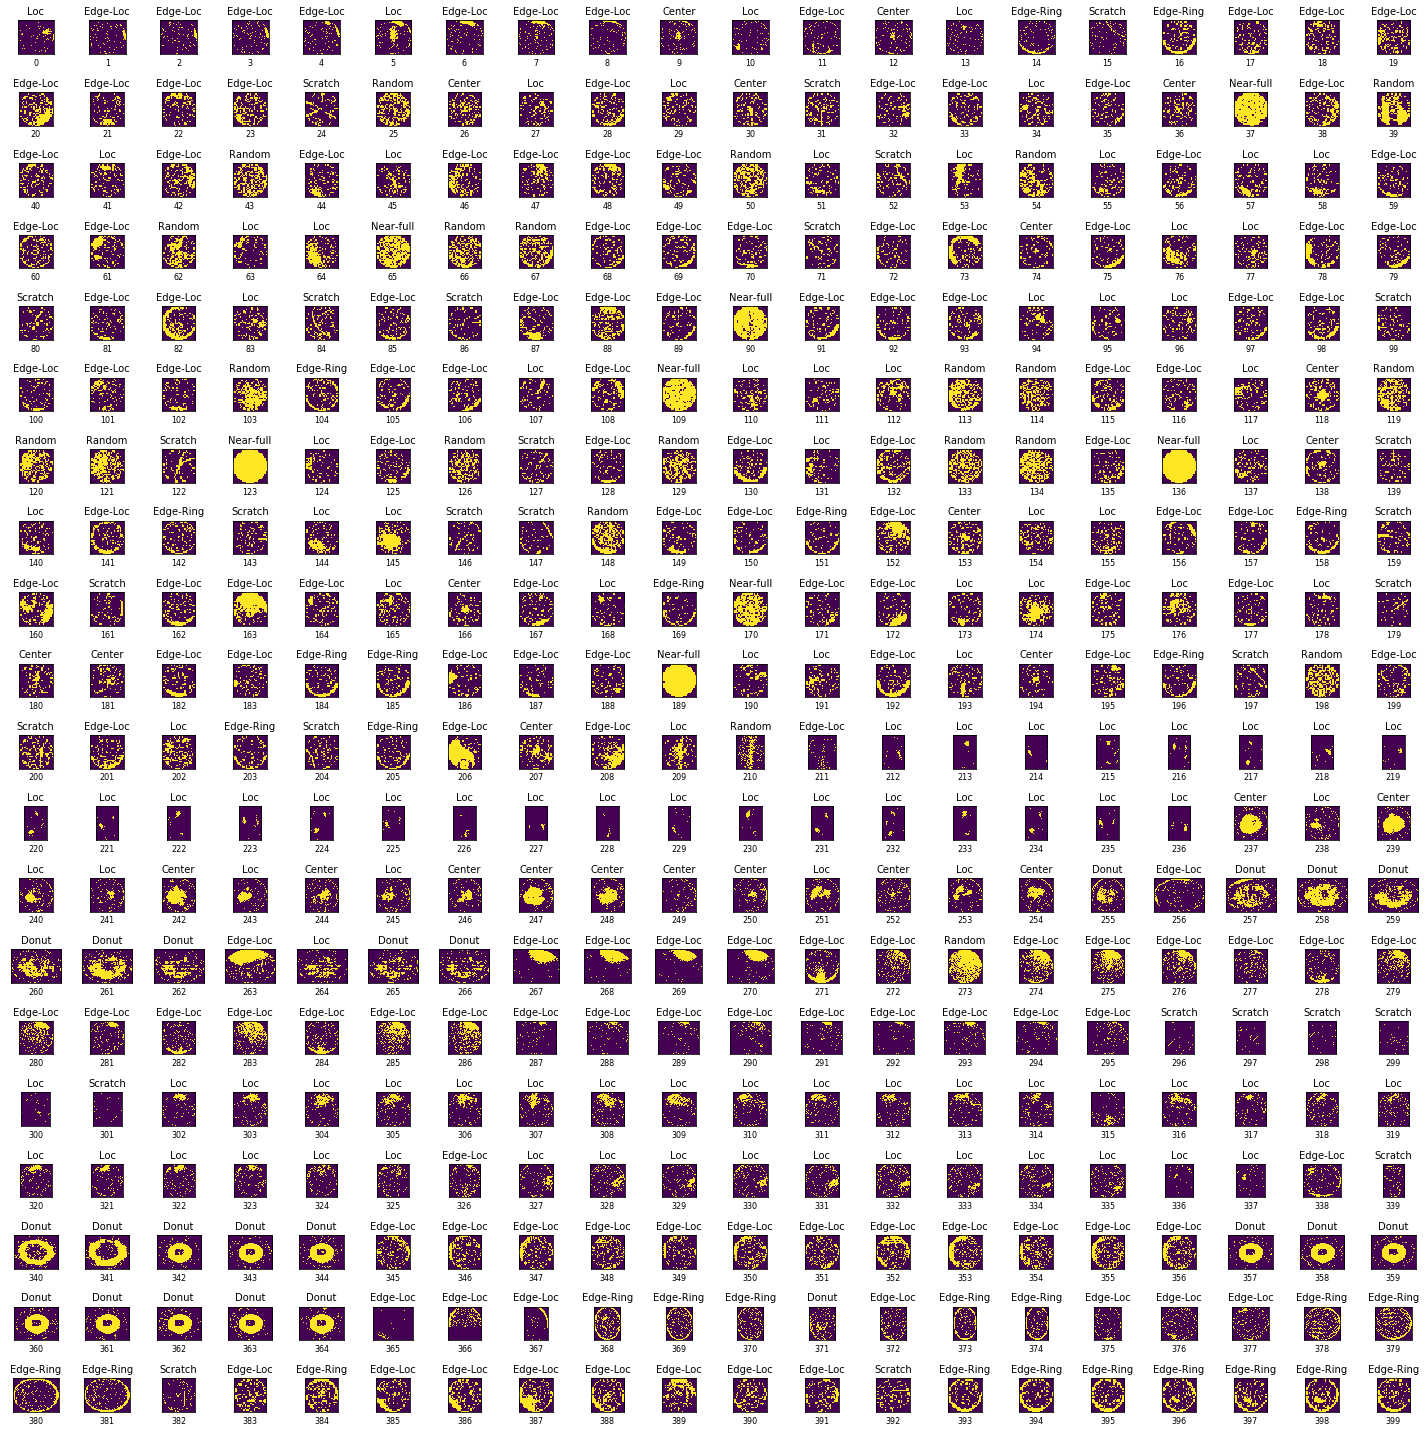

In [73]:
fig, ax = plt.subplots(nrows = 20, ncols = 20, figsize=(20, 20))
ax = ax.ravel(order='C')
for i in range(400):
    img = df_withpattern_copy.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern_copy.failureType[i][0][0], fontsize=10)
    ax[i].set_xlabel(df_withpattern_copy.index[i], fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

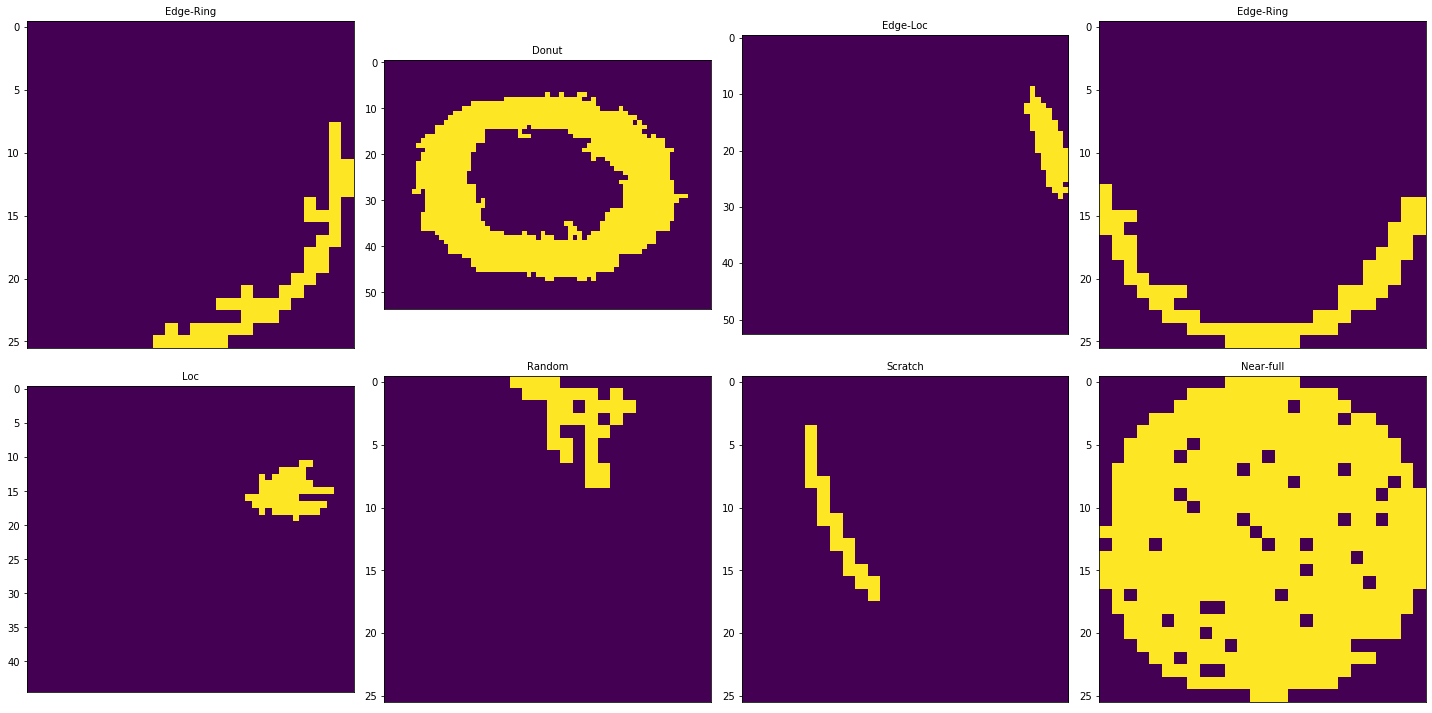

In [77]:
x = [398,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern_copy.waferMap[x[i]]
    zero_img = np.zeros(img.shape)
    img_labels = measure.label(img, neighbors=4, connectivity=1, background=0)
    img_labels = img_labels-1
    if img_labels.max()==0:
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels>-1], axis = None)
        no_region = info_region[0]
    
    zero_img[np.where(img_labels==no_region)] = 2 
    ax[i].imshow(zero_img)
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
plt.tight_layout()
plt.show() 

In [31]:
def cal_dist(img,x,y):
    dim0=np.size(img,axis=0)    
    dim1=np.size(img,axis=1)
    dist = np.sqrt((x-dim0/2)**2+(y-dim1/2)**2)
    return dist  

def fea_geom(img):
    norm_area=img.shape[0]*img.shape[1]
    norm_perimeter=np.sqrt((img.shape[0])**2+(img.shape[1])**2)
    
    img_labels = measure.label(img, neighbors=4, connectivity=1, background=0)

    if img_labels.max()==0:
        img_labels[img_labels==0]=1
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels>0], axis = None)
        no_region = info_region[0][0]-1       
    
    prop = measure.regionprops(img_labels)
    prop_area = prop[no_region].area/norm_area
    prop_perimeter = prop[no_region].perimeter/norm_perimeter 
    
    prop_cent = prop[no_region].local_centroid 
    prop_cent = cal_dist(img,prop_cent[0],prop_cent[1])
    
    prop_majaxis = prop[no_region].major_axis_length/norm_perimeter 
    prop_minaxis = prop[no_region].minor_axis_length/norm_perimeter  
    prop_ecc = prop[no_region].eccentricity  
    prop_solidity = prop[no_region].solidity  
    
    return prop_area,prop_perimeter,prop_majaxis,prop_minaxis,prop_ecc,prop_solidity

df_withpattern_copy['fea_geom'] =df_withpattern_copy.waferMap.apply(fea_geom)

/home/ds4user4/miniconda3/envs/dm_env/lib/python3.7/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/home/ds4user4/miniconda3/envs/dm_env/lib/python3.7/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


In [79]:
df_withpattern_copy.fea_geom[360]

AttributeError: 'DataFrame' object has no attribute 'fea_geom'

In [40]:
df_withpattern_copy

,index,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum,fea_reg,new_waferMap,fea_cub_mean,fea_cub_std,fea_geom
0,19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,20.0,[[Training]],[[Loc]],"(45, 48)",4,0,"[3.4722222222222223, 13.703703703703704, 3.472...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.020948312198063167, 0.026683150603641764, 0...","[0.010306353895205664, 0.016225705729273614, 0...","(0.027314814814814816, 0.5954493227790636, 0.1..."
1,36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12.0,[[Training]],[[Edge-Loc]],"(53, 58)",2,0,"[6.0344827586206895, 11.05121293800539, 5.1724...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.05379317347428998, 0.0598186325125214, 0.05...","[0.03796203303455247, 0.036241439592491875, 0....","(0.01626545217957059, 0.42137276857016587, 0.2..."
2,37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,13.0,[[Training]],[[Edge-Loc]],"(53, 58)",2,0,"[5.862068965517241, 11.320754716981133, 5.0397...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.04420250213707408, 0.06033372907944151, 0.0...","[0.030784539876323017, 0.041921149511889695, 0...","(0.019193233571893297, 0.4595560383749584, 0.2..."
3,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,14.0,[[Training]],[[Edge-Loc]],"(53, 58)",2,0,"[5.689655172413794, 16.037735849056602, 4.9071...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.06670148076593406, 0.07083150909994845, 0.0...","[0.04249425363651626, 0.05818754382060698, 0.0...","(0.025374105400130124, 0.49864384199138284, 0...."
4,39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,15.0,[[Training]],[[Edge-Loc]],"(53, 58)",2,0,"[11.551724137931034, 13.07277628032345, 5.0397...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.0640595915524978, 0.0696612239701709, 0.084...","[0.03077572398072894, 0.048465200407665394, 0....","(0.019843851659076123, 0.5065518560958309, 0.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25514,811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2,...",600.0,lot47542,21.0,[[Test]],[[Edge-Loc]],"(26, 30)",2,1,"[8.666666666666668, 21.153846153846153, 12.777...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2,...","[0.03221958716524163, 0.08024342807045874, 0.0...","[0.027967848803154026, 0.0492729973931846, 0.0...","(0.03076923076923077, 0.5394162468538333, 0.31..."
25515,811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",600.0,lot47542,22.0,[[Test]],[[Edge-Loc]],"(26, 30)",2,1,"[1.3333333333333335, 12.179487179487179, 7.222...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.03216605461998753, 0.04505181629880516, 0.0...","[0.027092115628165127, 0.02505532898484561, 0....","(0.019230769230769232, 0.35787184975239533, 0...."
25516,811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]],"(26, 30)",3,1,"[3.3333333333333335, 14.743589743589745, 16.11...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,...","[0.06052167486923029, 0.10084405992101803, 0.0...","[0.04261373167352511, 0.0357707475798425, 0.03...","(0.017948717948717947, 0.30749257756640747, 0...."
25517,811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]],"(26, 30)",2,1,"[3.3333333333333335, 23.717948717948715, 15.55...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0,...","[0.03769587642803953, 0.09558455494101789, 0.0...","[0.02772428416098711, 0.060102574782748254, 0....","(0.05, 0.8434820522885769, 0.5139658342457923,..."


In [33]:
df_all=df_withpattern_copy.copy()
a=[df_all.fea_reg[i] for i in range(df_all.shape[0])] #13
b=[df_all.fea_cub_mean[i] for i in range(df_all.shape[0])] #20
c=[df_all.fea_cub_std[i] for i in range(df_all.shape[0])] #20
d=[df_all.fea_geom[i] for i in range(df_all.shape[0])] #6
fea_all = np.concatenate((np.array(a),np.array(b),np.array(c),np.array(d)),axis=1) #59 in total

In [34]:
label=[df_all.failureNum[i] for i in range(df_all.shape[0])]
label=np.array(label)

In [36]:
import theano
from theano import tensor as T
from sklearn.cross_validation import train_test_split
from keras.utils import np_utils

ModuleNotFoundError: No module named 'theano'

In [38]:
from sklearn.cross_validation import train_test_split
X = fea_all
y = label

from collections import  Counter
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)                      
print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

RANDOM_STATE =42

ModuleNotFoundError: No module named 'sklearn.cross_validation'

ModuleNotFoundError: No module named 'tensorflow'